In [9]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

### Problem 1

Derive/show how to compute linear regression coefficients (for general choice of y and X) using the following four methods: naive linear algebra; QR decomposition; SVD; and Cholesky decomposition.

Optionally, look up the computational (time) complexity of each of these methods as a function of $p$ (number of predictors/columns of X) and $n$ (number of observations/length of y/rows of X)

Pick three of the four algorithms and implement them in the language of your choice. Benchmark your algorithms for a range of magnitudes of $p$ and $n$ covering at least one order of magnitude in $p$ and at least two orders of magnitude in $n$.  Plot your results on a log-log scale. Fit a log-log model to the average times (you can leave out some points if they mess up the scaling relationship).

1. Naive linear algebra

The residual sum-of-squares can be written as

$$
\begin{align}
\text{RSS}(\beta) &= (\mathbf{y}-\mathbf{X}\beta)^T(\mathbf{y}-\mathbf{X}\beta) \\
&= (\mathbf{y}^T-\beta^T\mathbf{X}^T)(\mathbf{y}-\mathbf{X}\beta) \\
&= \mathbf{y}^T\mathbf{y}-\mathbf{y}^T\mathbf{X}\beta - \beta^T\mathbf{X}^T\mathbf{y} + \beta^T\mathbf{X}^T\mathbf{X}\beta \\
&= \mathbf{y}^T\mathbf{y}-2\beta^T\mathbf{X}^T\mathbf{y} + \beta^T\mathbf{X}^T\mathbf{X}\beta
\end{align}
$$

where the last equality is due to the special case that $\mathbf{y}$ and $\beta$ are vectors, such that $\mathbf{y}^T\mathbf{X}\beta$ and $\beta^T\mathbf{X}^T\mathbf{y}$ are scalars and therefore symmetric.

Differentiating w.r.t. $\beta$:

$$
\begin{align}
\frac{\partial \text{RSS}}{\partial \beta} &= -2\mathbf{X}^T\mathbf{y} + 2\mathbf{X}^T\mathbf{X}\beta\\
&= -2\mathbf{X}^T(\mathbf{y}-\mathbf{X}\beta)
\end{align}
$$

Setting the derivative to zero gives 

$$
\begin{align}
\mathbf{X}^T(\mathbf{y}-\mathbf{X}\beta)&=0\\
\mathbf{X}^T\mathbf{X}\beta &= \mathbf{X}^T\mathbf{y} \\
\beta &= (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}
\end{align}$$


Resources:   
http://www.gatsby.ucl.ac.uk/teaching/courses/sntn/sntn-2017/resources/Matrix_derivatives_cribsheet.pdf  
https://math.stackexchange.com/questions/2753210/when-can-we-say-that-a-mathrm-t-b-b-mathrm-t-a

In [2]:
def ls_naive(X,y):
    return np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X)), X.T), y)

2. QR decomposition

Given the factorization $\mathbf{X}=\mathbf{Q}\mathbf{R}$ where $\mathbf{Q}$ is an orthogonal matrix ($\mathbf{Q}^T\mathbf{Q}=\mathbf{I}$) and $\mathbf{R}$ is an upper triangular matrix, the equation for $\beta$ simplifies to:

$$
\begin{align}
\beta &= (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y} \\
&= (\mathbf{R}^T\mathbf{Q}^T\mathbf{Q}\mathbf{R})^{-1}\mathbf{R}^T\mathbf{Q}^T\mathbf{y} \\
&= (\mathbf{R}^T\mathbf{R})^{-1}\mathbf{R}^T\mathbf{Q}^T\mathbf{y} \\
&= \mathbf{R}^{-1}\mathbf{Q}^T\mathbf{y}
\end{align}
$$

As $\mathbf{R}$ is an upper triangular matrix, the equation 

$$\mathbf{R}\beta=\mathbf{Q}^T\mathbf{y}$$

can be solved by back substitution.

QR decomposition can be computed using e.g. the Gram-Schmidt method

Resources:  
For realizing that $\beta = \mathbf{R}^{-1}\mathbf{Q}^T\mathbf{y}$ should be re-arranged to $\mathbf{R}\beta=\mathbf{Q}^T\mathbf{y}$ and solved using backward substitution: https://stats.stackexchange.com/questions/160007/understanding-qr-decomposition  
Implementation of Gram-Schmidt for QR decomposition: https://en.wikipedia.org/wiki/QR_decomposition

In [3]:
def GramSchmidt_QR(X):
    U = np.zeros(X.shape)
    U[:,0] = X[:,0]
    for col_i in range(1,X.shape[1]):
        a_i = X[:,col_i]
        U[:,col_i] = a_i 
        for i in range(col_i):
            u = U[:,i]
            U[:,col_i] -= np.dot(u, a_i)/np.dot(u,u) * u
    Q = np.divide(U, np.linalg.norm(U, axis=0))
    R = np.matmul(Q.T, X)
    return Q, R

def ls_QR(X,y):
    Q, R = GramSchmidt_QR(X)
    beta = np.linalg.solve(R, np.matmul(Q.T, y))
    return beta

3. SVD

SVD can be used to decompose $\mathbf{X}$ into the product of $\mathbf{U}\mathbf{S}\mathbf{V}^T$ where $\mathbf{U}$ and $\mathbf{V}$ are unitary matrices. The equation for $\beta$ can then be simplified:

$$
\begin{align}
\beta &= (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y} \\
&= (\mathbf{V}\mathbf{S}^T\mathbf{U}^T\mathbf{U}\mathbf{S}\mathbf{V}^T)^{-1}\mathbf{V}\mathbf{S}^T\mathbf{U}^T\mathbf{y}\\
&= (\mathbf{V}\mathbf{S}^T\mathbf{S}\mathbf{V}^T)^{-1}\mathbf{V}\mathbf{S}^T\mathbf{U}^T\mathbf{y} \\
&= \mathbf{V}\mathbf{S}^{-1}(\mathbf{S}^T)^{-1}\mathbf{V}^T\mathbf{V}\mathbf{S}^T\mathbf{U}^T\mathbf{y} \\
&= \mathbf{V}\mathbf{S}^{-1}\mathbf{U}^T\mathbf{y}
\end{align}
$$


Resources used:  
https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse

In [4]:
def ls_SVD(X,y):
    u, s, vh = np.linalg.svd(X)
    s_pseudoinv = np.zeros([u.shape[1],vh.shape[0]])
    s_pseudoinv[:len(s),:len(s)] = np.diag(1/s)
    s_pseudoinv = s_pseudoinv.T
    X_pseudoinv = np.matmul(np.matmul(vh.T, s_pseudoinv),u.T)
    
    return np.matmul(X_pseudoinv,y)

4. Cholesky decomposition

Alternatively, we can solve $\mathbf{X}^T\mathbf{X} \beta = \mathbf{X}^T\mathbf{y}$ by applying a Cholesky decomposition to $\mathbf{X}^T\mathbf{X}$, i.e. $\mathbf{X}^T\mathbf{X}=\mathbf{L}\mathbf{L}^T$, where $\mathbf{L}$ is lower triangular. We solve for $\beta$ by first solving  
  
$$\mathbf{L}\mathbf{b} = \mathbf{X}^T\mathbf{y}$$

by forward substitution, then 

$$\mathbf{L}^T\beta = \mathbf{b} $$

by backward substitution

Resources used:  
https://en.wikipedia.org/wiki/Cholesky_decomposition  
https://numpy.org/doc/stable/reference/generated/numpy.linalg.cholesky.html

In [5]:
def ls_cholesky(X,y):
    L = np.linalg.cholesky(np.matmul(X.T, X))
    b1 = np.linalg.solve(L, np.matmul(X.T,y))
    beta = np.linalg.solve(L.T, b1)
    return beta

### Problem 2

Implement ridge regression by data augmentation in the language of your choice.  Compare results and timing with a native implementation of ridge regression.

1. Data augmentation

From the notes, using the augmented data matrix

$$\mathbf{B} = \left[ {\begin{array}{c} \mathbf{X} \\ \sqrt{\lambda}\mathbf{I}\end{array} } \right]$$

and augmented observations $\mathbf{y}^* = (\mathbf{y} \hspace{1em} 0)$, we have

$$(\mathbf{B}^T\mathbf{B})\beta = \mathbf{B}^T\mathbf{y}^*$$

Applying QR decomposition: $\mathbf{B}=\mathbf{Q}\mathbf{R}$

$$
\begin{align}
(\mathbf{R}^T\mathbf{Q}^T\mathbf{Q}\mathbf{R})\beta &= \mathbf{R}^T\mathbf{Q}^T\mathbf{y}^* \\
\mathbf{R}^T\mathbf{R}\beta &= \mathbf{R}^T\mathbf{Q}^T\mathbf{y}^*
\end{align}
$$

which can be solved by first solving 

$$\mathbf{R}^T\mathbf{A} = \mathbf{R}^T\mathbf{Q}^T\mathbf{y}^*$$

then solving

$$\mathbf{R}\beta=\mathbf{A}$$

In [47]:
def ridge_augmentation(X,y,lamb):
    B = np.zeros([X.shape[0]+X.shape[1], X.shape[1]])
    B[:X.shape[0],:] = X
    B[X.shape[0]:,:] = np.diag(lamb**0.5 * np.ones(X.shape[1]))
    
    y_star = np.zeros(len(y)+X.shape[1])
    y_star[:len(y)] = y
    
    Q, R = np.linalg.qr(B)
    A = np.linalg.solve(R.T, np.matmul(np.matmul(R.T,Q.T),y_star))
    beta = np.linalg.solve(R, A)
    return beta

2. Naive implementation

$$\beta^{\text{ridge}} = (\mathbf{X}^T\mathbf{X}+\lambda\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}$$

In [7]:
def ridge_naive(X,y,lamb):
    XTX = np.matmul(X.T,X) 
    inv = np.linalg.inv(XTX + np.diag(lamb*np.ones(XTX.shape[0])))
    return np.matmul(np.matmul(inv, X.T),y)

In [100]:
def compute_RSS(X, y, beta):
    residuals = y - np.matmul(X,beta)
    return np.matmul(residuals.T, residuals)

def normalize_columns(A):
    """scale to have mean zero and variance 96 like in ESL"""
    A -= np.mean(A, axis=0)
    std = np.std(A, axis=0)
    std[std==0] = 1
    A /= std
    A *= 96**0.5
    A[:,-1] = 1 # restore the bias column
    return A

In [101]:
prostate_data = pd.read_csv("prostate_cancer.txt", index_col=0, delimiter='\t')
prostate_data["train"].astype("category")
prostate_data.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [102]:
prostate_data["bias"] = 1 # add bias column for regression
train_set = prostate_data[prostate_data["train"]=="T"]
test_set = prostate_data[prostate_data["train"]=="F"]

train_X = train_set[["lcavol", "lweight", "age", "lbph", "svi", "lcp", "gleason", "pgg45", "bias"]].to_numpy()
train_X = normalize_columns(train_X)
train_Y = train_set["lpsa"].to_numpy()

test_X = test_set[["lcavol", "lweight", "age", "lbph", "svi", "lcp", "gleason", "pgg45", "bias"]].to_numpy()
test_X = normalize_columns(test_X)
test_Y = test_set["lpsa"].to_numpy()

In [103]:
n = 20
lambdas = np.linspace(0, 5, n)

RSS_aug = np.zeros(n)
RSS_naive = np.zeros(n)
for i in range(len(lambdas)):
    beta_aug = ridge_augmentation(train_X, train_Y, lambdas[i])
    beta_naive = ridge_naive(train_X, train_Y, lambdas[i])
    RSS_aug[i] = compute_RSS(test_X, test_Y, beta_aug)
    RSS_naive[i] = compute_RSS(test_X, test_Y, beta_naive)

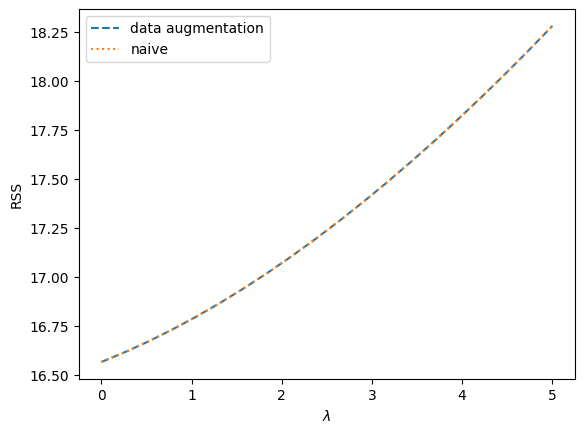

In [104]:
plt.plot(lambdas, RSS_aug, ls='dashed', label="data augmentation")
plt.plot(lambdas, RSS_naive, ls='dotted', label="naive")
plt.legend(loc='best')
plt.xlabel("$\lambda$")
plt.ylabel("RSS")
plt.show()

In [105]:
%timeit -r 10 ridge_augmentation(train_X, train_Y, 1)

28.6 µs ± 2.16 µs per loop (mean ± std. dev. of 10 runs, 10,000 loops each)


In [106]:
%timeit -r 10 ridge_naive(train_X, train_Y, 1)

20.5 µs ± 2.36 µs per loop (mean ± std. dev. of 10 runs, 10,000 loops each)
